In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
# --- Load the dataset ---
try:
    df = pd.read_csv("C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/MI/Michigan_CrashDataset_2022.csv", low_memory=False)
except FileNotFoundError:
    # Fallback to Excel if CSV is not available
    df = pd.read_excel("C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/MI/Michigan_CrashDataset_2022.xlsx")

print("Data loaded. Shape:", df.shape)

Data loaded. Shape: (364105, 154)


In [81]:
# 1. Filter to drivers only
df = df[df["Party Type"] == "Motor Vehicle Driver"].copy()
print(f"Total records (drivers only): {len(df)}")  # Expect ~305,786 drivers

# 2. Drop the one incomplete crash record (Crash Year is NaN)
df = df[~df["Crash Year"].isna()].copy()

# 3. Generate AccidentID by grouping on date/time/location (to identify unique crashes)
df["AccidentID"] = df.groupby(["Crash Year", "Crash Month", "Crash Day", "Time of Day", "City or Township", "County"]).ngroup()

# Create PersonID as unique index for each row (optional, here just use the DataFrame index)
df.reset_index(drop=True, inplace=True)
df["PersonID"] = df.index

# 4. Drop irrelevant or redundant columns
# Drop non-driver columns and older/deprecated fields
cols_to_drop = []

# Drop party type (now constant "Motor Vehicle Driver")
cols_to_drop.append("Party Type")

# Drop older year-specific fields (2004-2014/2015 versions)
for col in df.columns:
    if "(2004-201" in col or "(2004-2015)" in col or "(2004-2014)" in col:
        cols_to_drop.append(col)
# Also drop construction-related and detailed location fields
for col in ["Construction Activity (2016+)", "Construction Crash Location (2016+)",
            "Construction Type", "Construction Workers Present (2016+)",
            "Highway Number", "Control Section"]:
    if col in df.columns:
        cols_to_drop.append(col)
# Drop duplicate driver/person fields (keep person-level)
dup_fields = ["Driver Age", "Driver Gender", "Driver Position", "Driver Restraint",
              "Driver Ejection", "Driver Trapped", "Driver Degree of Injury"]
for col in dup_fields:
    if col in df.columns:
        cols_to_drop.append(col)
# Drop license endorsement type fields
license_fields = [c for c in df.columns if c.startswith("Driver License Type")]
cols_to_drop += license_fields
# Drop other fields not needed (Hazardous Action, citations, sequence of events, etc.)
other_drops = ["Hazardous Action", "Driver Other Citation", "Sequence of Events 1",
               "Sequence of Events 2", "Sequence of Events 3", "Sequence of Events 4",
               "Total Non-Motor Vehicles (2016+)", "Total Occupants in Unit",
               "Driveable After Crash (2004-2015)", "Special Vehicle"]  # drop Special Vehicle usage
for col in other_drops:
    if col in df.columns:
        cols_to_drop.append(col)
# Use a set to avoid duplicates
cols_to_drop = [c for c in set(cols_to_drop) if c in df.columns]
df.drop(columns=cols_to_drop, inplace=True)
print(f"Columns dropped: {len(cols_to_drop)} – {cols_to_drop}")

Total records (drivers only): 305786
Columns dropped: 41 – ['Extent of Damage (2004-2014)', 'Driver License Type - Chauffeur License', 'Driver License Type - Farm Equipment Endorsement', 'Party Type', 'Driver Other Citation', 'Driver Position', 'Driver License Type - Moped License', 'Driver Condition: Cell Phone (2004-2014)', 'Sequence of Events 2', 'Driveable After Crash (2004-2015)', 'Weather Conditions (2004-2015)', 'Sequence of Events 1', 'Sequence of Events 3', 'Driver Condition: Distracted (2004-2014)', 'Driver Condition: Fatigue (2004-2015)', 'Construction Activity (2004-2014)', 'Driver Gender', 'Construction Activity (2016+)', 'Driver License Type - Operator License', 'Driver Restraint', 'Driver Condition: Asleep (2004-2014)', 'Total Occupants in Unit', 'Driver Age', 'Total Non-Motor Vehicles (2016+)', 'Driver Trapped', 'Driver License Type - Recreational Double Enorsement', 'Construction Crash Location (2016+)', 'Control Section', 'Construction Workers Present (2016+)', 'Speci

In [82]:
# 5. Handle missing and "Unknown" values
# Replace "Uncoded & Errors" and blanks with "Unknown" for all object columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].replace("Uncoded & Errors", "Unknown")
    # Also replace any NaN in categorical columns with "Unknown" if that makes sense:
    if df[col].dtype == object:
        df[col] = df[col].fillna("Unknown")

In [83]:
# Fix specific fields:
# Person Age: replace "DOB Invalid" with NaN then impute with median
if "Person Age" in df.columns:
    invalid_mask = df["Person Age"].astype(str).str.contains("DOB Invalid", case=False, na=False)
    df.loc[invalid_mask, "Person Age"] = np.nan
    median_age = df["Person Age"].dropna().astype(float).median()
    df["AgeImputed"] = 0
    df.loc[invalid_mask, "AgeImputed"] = 1
    df["Person Age"] = df["Person Age"].astype(float)
    df.loc[df["Person Age"].isna(), "Person Age"] = median_age
    print(f"Imputed Age for {invalid_mask.sum()} drivers with 'DOB Invalid' using median age {median_age:.1f}.")

# Refusal fields: fill NaN with "No" (no refusal)
for col in ["Refusal Information - Alcohol", "Refusal Information - Drug (2016+)"]:
    if col in df.columns:
        df[col] = df[col].fillna("No")

# 6. Standardize categorical text
# Convert all string categories to a consistent case (lowercase)
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()
    df[col] = df[col].replace("", "Unknown")  # ensure no empty strings
    df[col] = df[col].str.capitalize()  # e.g., "male"/"Male" to "Male" (use capitalize for uniform case)
    # Note: We capitalize instead of lowercasing to preserve readability (e.g., "Unknown" instead of "unknown").

# 7. Encode binary/ordinal fields
# Map Yes/No/Unknown to 1/0/-1 for relevant fields
binary_yesno_fields = {
    "Driver Contributing Factor - Alcohol Use (2016+)": "Yes",
    "Driver Contributing Factor - Drug Use (2016+)": "Yes",
    "Drugs Suspected": "Drugs suspected",
    "Test Offered - Alcohol": "Test offered",
    "Test Offered - Drug (2016+)": "Test offered"
}
for col, yes_val in binary_yesno_fields.items():
    if col in df.columns:
        df[col] = df[col].replace({yes_val: 1, "Yes": 1, "No": 0, "Unknown": -1})

# Refusal fields: map "Refused" ->1, anything else ("No") ->0
for col in ["Refusal Information - Alcohol", "Refusal Information - Drug (2016+)"]:
    if col in df.columns:
        df[col] = np.where(df[col] == "Refused", 1, 0)

# Test result pending: map "Yes"->1, else 0
for col in ["Test Result Pending - Alcohol (2016+)", "Test Result Pending - Drug (2016+)"]:
    if col in df.columns:
        df[col] = np.where(df[col] == "Yes", 1, 0)

# Worst Injury in Crash: map to 0-4 (No Injury, Possible, Minor, Serious, Fatal)
severity_map = {
    "No Injury (O)": 0, "Possible Injury (C)": 1,
    "Suspected Minor Injury (B)": 2, "Suspected Serious Injury (A)": 3,
    "Fatal Injury (K)": 4, "Unknown": -1
}
if "Worst Injury in Crash" in df.columns:
    df["Worst Injury in Crash"] = df["Worst Injury in Crash"].map(severity_map).astype('Int64')
# Person Degree of Injury: map to 0-3 similarly (Fatal not present for drivers)
inj_map = {
    "No Injury (O)": 0, "Possible Injury (C)": 1,
    "Suspected Minor Injury (B)": 2, "Suspected Serious Injury (A)": 3,
    "Unknown": -1
}
if "Driver Degree of Injury" in df.columns:  # if not dropped
    df["Driver Degree of Injury"] = df["Driver Degree of Injury"].map(inj_map).astype("Int64")
if "Person Degree of Injury" in df.columns:
    df["Person Degree of Injury"] = df["Person Degree of Injury"].map(inj_map).astype("Int64")

# Restraint use: create Restrained flag (1 if not "None", else 0)
if "Person Restraint (2016+)" in df.columns:
    df["Restrained"] = np.where(df["Person Restraint (2016+)"].str.contains("None", case=False, na=False), 0, 1)

# Ejection/Trapped: binary flags
if "Person Ejection" in df.columns:
    df["Ejected"] = np.where(df["Person Ejection"].str.contains("Not Ejected", case=False, na=False) | (df["Person Ejection"] == "Unknown"), 0, 1)
if "Person Trapped" in df.columns:
    df["Trapped"] = np.where(df["Person Trapped"].str.contains("Not Trapped", case=False, na=False) | (df["Person Trapped"] == "Unknown"), 0, 1)

# Driver condition fields (Emotional, Fatigued, etc.): set flag =1 if value not "Unknown"
condition_fields = ["Driver Condition: Emotional (2016+)", "Driver Condition: Fatigued or Asleep (2016+)",
                    "Driver Condition: Physically Disabled (2016+)", "Driver Condition: Other (2016+)"]
for col in condition_fields:
    if col in df.columns:
        flag_name = col.split(":")[1].strip().replace(" ", "") + "Flag"  # e.g. EmotionalFlag
        df[flag_name] = np.where((df[col] != "Unknown") & (~df[col].isna()), 1, 0)

C:\Users\jason\AppData\Local\Temp\ipykernel_62480\507239346.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["AgeImputed"] = 0


Imputed Age for 17765 drivers with 'DOB Invalid' using median age 39.0.


C:\Users\jason\AppData\Local\Temp\ipykernel_62480\507239346.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Restrained"] = np.where(df["Person Restraint (2016+)"].str.contains("None", case=False, na=False), 0, 1)
C:\Users\jason\AppData\Local\Temp\ipykernel_62480\507239346.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Ejected"] = np.where(df["Person Ejection"].str.contains("Not Ejected", case=False, na=False) | (df["Person Ejection"] == "Unknown"), 0, 1)
C:\Users\jason\AppData\Local\Temp\ipykernel_62480\507239

In [84]:
# 8. Split and transform drug test result fields
# Create new Drug class/name columns
for i in [1, 2, 3]:
    class_col = f"Drug{i}_Class"
    name_col = f"Drug{i}_Name"
    src_col = f"Test Result - Drug {i}"
    if src_col not in df.columns:
        continue
    df[class_col] = "Unknown"
    df[name_col] = "Unknown"
    # Process only non-null entries
    mask = df[src_col].notna()
    for idx in df[mask].index:
        val = str(df.at[idx, src_col]).strip()
        if val == "" or val.lower().startswith("unknown"):
            # Includes "Reported as Unknown if Tested" (now "Unknown") and any unknown
            df.at[idx, class_col] = "Unknown"
            df.at[idx, name_col] = "Unknown"
        elif val.lower().startswith("negative"):
            df.at[idx, class_col] = "Negative"
            df.at[idx, name_col] = "Negative"
        elif val.lower().startswith("other drug"):
            df.at[idx, class_col] = "Other"
            df.at[idx, name_col] = "Other Drug"
        elif "unknown/positive" in val.lower():
            # "Tested for Drugs, Drugs Found, Type Unknown/Positive"
            df.at[idx, class_col] = "Unknown"
            df.at[idx, name_col] = "Unknown"
        elif ":" in val:
            # Split at the first colon
            parts = val.split(":", 1)
            df.at[idx, class_col] = parts[0].strip()
            df.at[idx, name_col] = parts[1].strip()
        else:
            # Any other unexpected case, treat as class=Other
            df.at[idx, class_col] = "Other"
            df.at[idx, name_col] = val.strip()
    # Drop the original Test Result column after processing
    df.drop(columns=[src_col], inplace=True, errors='ignore')

# We keep "Test Result - Cannabinoid Drug (2021+)" as is (to integrate later if needed)

C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2188448959.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[class_col] = "Unknown"
C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2188448959.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name_col] = "Unknown"
C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2188448959.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

In [85]:
# 9. Derive opioid and drug flags
df["Opioid_Involved_Driver"] = 0
df["Any_Drug_Positive_Driver"] = 0
# Mark opioid involved if any drug class is Narcotics
narcotics_mask = ((df["Drug1_Class"] == "Narcotics") | (df.get("Drug2_Class", "") == "Narcotics") | (df.get("Drug3_Class", "") == "Narcotics"))
df.loc[narcotics_mask, "Opioid_Involved_Driver"] = 1
# Mark any drug positive if any Drug1/2/3_Class is not Unknown/Negative
drug_found_mask = ((df["Drug1_Class"].isin(["Narcotics", "Depressants", "Stimulants", "Cannabinoids", "Hallucinogens", "Other"])) |
                   (df.get("Drug2_Class", "").isin(["Narcotics", "Depressants", "Stimulants", "Cannabinoids", "Hallucinogens", "Other"])) |
                   (df.get("Drug3_Class", "").isin(["Narcotics", "Depressants", "Stimulants", "Cannabinoids", "Hallucinogens", "Other"])))
df.loc[drug_found_mask, "Any_Drug_Positive_Driver"] = 1

# Aggregate to crash level for crash opioid flag
opioid_crash = df.groupby("AccidentID")["Opioid_Involved_Driver"].max()
df["Opioid_Involved_Crash"] = df["AccidentID"].map(opioid_crash)  # 1 if any driver in crash had opioid

C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2133802975.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Opioid_Involved_Driver"] = 0
C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2133802975.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Any_Drug_Positive_Driver"] = 0
C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2133802975.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

In [86]:
# Convert 'Crash Month' to numeric before comparison
# 'coerce' will turn any values that can't be converted into NaN (Not a Number)
print("Unique Crash Month values BEFORE conversion:", df['Crash Month'].unique())
month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4,
             'May': 5, 'June': 6, 'July': 7, 'August': 8,
             'September': 9, 'October': 10, 'November': 11, 'December': 12}
# Make sure keys match the exact strings in your data (case-sensitive!)
# You might need to capitalize them first if needed: df['Crash Month'].str.capitalize().map(month_map)
df['Crash Month'] = df['Crash Month'].str.strip().map(month_map)
# Check for NaNs again after mapping in case some values didn't match
print(f"Number of rows with invalid Crash Month AFTER mapping: {df['Crash Month'].isna().sum()}")

# Check if any values failed to map (resulting in NaN)
invalid_month_count = df['Crash Month'].isna().sum()
if invalid_month_count > 0:
    print(f"Warning: {invalid_month_count} rows had 'Crash Month' values that did not match the map (e.g., typos, different capitalization?) and resulted in NaN.")
    # Decide how to handle these NaNs. You could drop them:
    # df.dropna(subset=['Crash Month'], inplace=True)
    # Or fill them with a placeholder if appropriate, though dropping is often safer.
else:
    print("Successfully mapped all Crash Month names to numbers.")
    # If mapping was successful and no NaNs remain, you can convert to integer type
    # Using 'Int64' (nullable integer) is often safer than 'int'
    df['Crash Month'] = df['Crash Month'].astype('Int64')

# Verify the result
print("Unique Crash Month values AFTER mapping:", df['Crash Month'].unique())

# 10. Split into training and testing sets by date (month)
# Now this comparison should work correctly
train_df = df[df["Crash Month"] <= 9].copy()  # crashes Jan–Sept 2022
test_df  = df[df["Crash Month"] >= 10].copy() # crashes Oct–Dec 2022
print(f"Training set: {len(train_df)} drivers, Testing set: {len(test_df)} drivers")

# Optional: You might want to check for and handle any NaNs introduced by 'coerce'
print(f"Number of rows with invalid Crash Month: {df['Crash Month'].isna().sum()}")
# df.dropna(subset=['Crash Month'], inplace=True) # Example: remove rows with invalid month

Unique Crash Month values BEFORE conversion: ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'
 'September' 'October' 'November' 'December']
Number of rows with invalid Crash Month AFTER mapping: 0
Successfully mapped all Crash Month names to numbers.
Unique Crash Month values AFTER mapping: <IntegerArray>
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Length: 12, dtype: Int64
Training set: 227952 drivers, Testing set: 77834 drivers
Number of rows with invalid Crash Month: 0


In [87]:
# 11. Example visualization: Top drug test results (excluding Unknown)
# Combine Drug Name fields and count occurrences
drug_names = pd.concat([df["Drug1_Name"], df["Drug2_Name"], df["Drug3_Name"]]).dropna()
drug_names = drug_names[~drug_names.isin(["Unknown", "Negative", "Other Drug"])]
top_drugs = drug_names.value_counts().head(10)
print("Top substances found (excluding 'Unknown' and 'Negative'):\n", top_drugs)

Top substances found (excluding 'Unknown' and 'Negative'):
 Reported as unknown if tested for drugs    915436
tetrahydrocannabinols (thc)                   438
fentanyl                                      168
amphetamine                                   154
benzoylecgonine                               103
methamphetamine                                78
cocaine                                        71
alprazolam                                     63
delta 9                                        55
cannabinoid, type unknown                      43
Name: count, dtype: int64


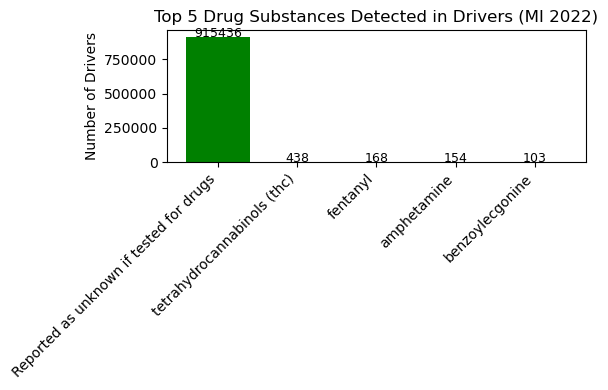

In [88]:
# Plot top 5 substances vs their counts
top5 = top_drugs.head(5)
plt.figure(figsize=(6,4))
bars = plt.bar(top5.index, top5.values, color=['green','orange','orange','blue','blue'])
plt.title("Top 5 Drug Substances Detected in Drivers (MI 2022)")
plt.ylabel("Number of Drivers")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', fontsize=9)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [89]:
def plot_drug_factor_distribution(df_to_plot):
    """
    Creates a bar plot showing the distribution of the Drug Use Contributing Factor.
    Uses the state of the data AFTER cleaning Step #6 (.str.capitalize()).
    """
    factor_col = 'Driver Contributing Factor - Drug Use (2016+)' # Use the confirmed column name

    if factor_col not in df_to_plot.columns:
        print(f"Error in plot_drug_factor_distribution: Missing column '{factor_col}'. Skipping plot.")
        return

    # Filter based on the CAPITALIZED strings expected after Step #6
    valid_factors = [
        'Drug use was a contributing factor', # Capitalized by Step #6
        'Drug use was not a contributing factor' # Capitalized by Step #6
    ]
    df_factor = df_to_plot.loc[df_to_plot[factor_col].isin(valid_factors)].copy()

    if df_factor.empty:
        print(f"Warning in plot_drug_factor_distribution: No data found for factors {valid_factors}. Plot may be empty.")
        return

    data_counts = df_factor[factor_col].value_counts().reset_index()
    if not data_counts.empty:
        data_counts.columns = ['DrugFactor', 'Count']
        plt.figure(figsize=(7, 5)) # Slightly larger figure
        sns.barplot(data=data_counts, x='DrugFactor', y='Count', palette='viridis')
        plt.title("Distribution of 'Drug Use' Contributing Factor (MI 2022 Drivers)")
        plt.xlabel("Contributing Factor for Drugs")
        plt.ylabel("Number of Drivers")
        plt.xticks(rotation=15, ha='right') # Rotate labels slightly
        plt.tight_layout()
        plt.show()
    else:
        print("Warning in plot_drug_factor_distribution: No data counts available to plot.")

In [90]:
def plot_severity_by_drug_factor(df_to_plot):
    """
    Creates a stacked bar of Crash Severity (Worst Injury in Crash)
    comparing drivers based on Drug Use Contributing Factor.
    Uses data AFTER Step #6 (Capitalization) and Step #7 (Severity Encoding).
    """
    factor_col = 'Driver Contributing Factor - Drug Use (2016+)' # Use confirmed name
    severity_col = 'Worst Injury in Crash' # This column IS encoded to numbers (0-4)

    if factor_col not in df_to_plot.columns or severity_col not in df_to_plot.columns:
        print(f"Error in plot_severity_by_drug_factor: Missing required columns '{factor_col}' or '{severity_col}'. Skipping plot.")
        return

    # Create binary factor flag based on CAPITALIZED strings
    valid_factor_strings = [
        'Drug use was a contributing factor',
        'Drug use was not a contributing factor'
    ]
    df_sub = df_to_plot.loc[df_to_plot[factor_col].isin(valid_factor_strings)].copy()
    df_sub['DrugFactorBinary'] = df_sub[factor_col].apply(lambda x: 1 if 'was a contributing' in x else 0)

    if df_sub.empty:
        print(f"Warning in plot_severity_by_drug_factor: No data rows found after filtering by factor column '{factor_col}'. Skipping plot.")
        return

    # Filter based on ENCODED severity values (0 to 4)
    valid_severity_codes = [0, 1, 2, 3, 4] # Use the numeric codes
    df_sub = df_sub.loc[df_sub[severity_col].isin(valid_severity_codes)]

    if df_sub.empty:
        print(f"Warning in plot_severity_by_drug_factor: No data rows found after filtering by severity codes {valid_severity_codes}. Skipping plot.")
        return

    # Map severity codes back to labels FOR PLOTTING ONLY
    severity_labels_map = {
        0: "No Injury (O)", 1: "Possible Injury (C)", 2: "Minor Injury (B)",
        3: "Serious Injury (A)", 4: "Fatal Injury (K)"
    }
    df_sub['SeverityLabel'] = df_sub[severity_col].map(severity_labels_map)

    # Group and pivot using the labels
    pivot_data = df_sub.groupby(['DrugFactorBinary', 'SeverityLabel']).size().reset_index(name='Count')

    # Ensure columns have a consistent order based on severity
    severity_order = [severity_labels_map[i] for i in valid_severity_codes if i in severity_labels_map]
    pivot_wide = pivot_data.pivot(index='DrugFactorBinary', columns='SeverityLabel', values='Count').fillna(0)

    # Ensure pivot table has both 0 and 1 index if data exists for them
    if 0 not in pivot_wide.index and not pivot_wide.empty: pivot_wide.loc[0] = 0
    if 1 not in pivot_wide.index and not pivot_wide.empty: pivot_wide.loc[1] = 0
    pivot_wide = pivot_wide.sort_index()

    pivot_wide = pivot_wide.reindex(columns=severity_order, fill_value=0) # Order columns

    # Stacked bar
    if not pivot_wide.empty:
        pivot_wide.plot(kind='bar', stacked=True, figsize=(8,6), colormap='Paired')
        plt.title("Crash Severity Distribution by Drug Factor (MI 2022 Drivers)")
        plt.xlabel("Drug Use Contributing Factor (0=No, 1=Yes)")
        plt.ylabel("Number of Drivers")
        plt.xticks(rotation=0)
        plt.legend(title='Worst Injury in Crash', bbox_to_anchor=(1.05,1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("Warning in plot_severity_by_drug_factor: Pivot table is empty, cannot generate plot.")

In [91]:
def plot_age_distribution_by_drug_factor(df_to_plot):
    """
    Plots age distribution KDE based on Drug Use Contributing Factor.
    Uses data AFTER Step #6 (Capitalization).
    """
    factor_col = 'Driver Contributing Factor - Drug Use (2016+)' # Use confirmed name
    age_col = 'Person Age'

    if factor_col not in df_to_plot.columns or age_col not in df_to_plot.columns:
        print(f"Error in plot_age_distribution_by_drug_factor: Missing column '{factor_col}' or '{age_col}'. Skipping plot.")
        return

    # Filter based on CAPITALIZED strings and valid age
    valid_factors = [
        'Drug use was a contributing factor',
        'Drug use was not a contributing factor'
    ]
    df_sub = df_to_plot.loc[
        (df_to_plot[factor_col].isin(valid_factors)) &
        (df_to_plot[age_col].notna()) # Ensure age is not NaN
    ].copy()

    df_sub['DrugFactorBinary'] = df_sub[factor_col].apply(lambda x: 1 if 'was a contributing' in x else 0)

    if df_sub.empty:
         print(f"Warning in plot_age_distribution_by_drug_factor: No data found after filtering. Skipping plot.")
         return
    if df_sub['DrugFactorBinary'].nunique() < 2:
         print(f"Warning in plot_age_distribution_by_drug_factor: Only one category of DrugFactorBinary found. KDE plot might look strange.")

    plt.figure(figsize=(8,5))
    sns.kdeplot(data=df_sub, x=age_col, hue='DrugFactorBinary', fill=True, common_norm=False, palette='viridis', bw_adjust=0.75)
    plt.title("Age Distribution: Drug Factor (0=No, 1=Yes) (MI 2022 Drivers)")
    plt.xlabel("Driver Age")
    plt.ylabel("Density")
    handles, labels = plt.gca().get_legend_handles_labels()
    if labels:
        new_labels = ['Factor=No' if label == '0' else ('Factor=Yes' if label == '1' else label) for label in labels]
        plt.legend(handles=handles, labels=new_labels, title="Drug Factor")
    plt.tight_layout()
    plt.show()

In [92]:
def plot_drug_factor_by_county(df_to_plot, top_n=15):
    """
    Plots top N counties by count of drivers where drug use was a contributing factor.
    Uses data AFTER Step #6 (Capitalization).
    """
    factor_col = 'Driver Contributing Factor - Drug Use (2016+)' # Use confirmed name
    county_col = 'County'

    if factor_col not in df_to_plot.columns or county_col not in df_to_plot.columns:
        print(f"Error in plot_drug_factor_by_county: Missing column '{factor_col}' or '{county_col}'. Skipping plot.")
        return

    # Filter based on the specific CAPITALIZED string
    factor_string = 'Drug use was a contributing factor' # After Step #6
    df_drug = df_to_plot.loc[df_to_plot[factor_col] == factor_string].copy()

    if df_drug.empty:
        print(f"Warning in plot_drug_factor_by_county: No drivers found where '{factor_string}'. Skipping plot.")
        return

    county_counts = df_drug[county_col].value_counts().head(top_n)

    if county_counts.empty:
        print(f"Warning in plot_drug_factor_by_county: No county counts available to plot.")
        return

    plt.figure(figsize=(8,6))
    sns.barplot(x=county_counts.values, y=county_counts.index, palette='coolwarm')
    plt.title(f"Top {top_n} Counties with 'Drug Use Contributing Factor' (MI 2022)")
    plt.xlabel("Number of Drivers (Drug Factor = Yes)")
    plt.ylabel("County")
    plt.tight_layout()
    plt.show()

# --- Load the dataset ---
try:
    # IMPORTANT: Ensure this file path is correct for your system
    df = pd.read_csv("C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/MI/Michigan_CrashDataset_2022.csv", low_memory=False)
    print("CSV Data loaded.")
except FileNotFoundError:
    try:
      # Fallback to Excel if CSV is not available
      # IMPORTANT: Ensure this file path is correct for your system
      df = pd.read_excel("C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/MI/Michigan_CrashDataset_2022.xlsx")
      print("Excel Data loaded.")
    except FileNotFoundError:
      print("Error: Neither CSV nor Excel file found at the specified paths.")
      # Optionally, stop the script if no data is loaded
      import sys
      sys.exit("Exiting script - data file not found.")


print("Initial Data loaded. Shape:", df.shape)

CSV Data loaded.
Initial Data loaded. Shape: (364105, 154)


In [93]:
def plot_severity_by_opioid_involvement(df_to_plot):
    """
    Creates a stacked bar chart of Crash Severity vs. Opioid Involvement.
    Uses the 'Opioid_Involved_Driver' flag (0=No, 1=Yes) and
    the numeric 'Worst Injury in Crash Numeric' column (0-4).
    Adds a label showing the total count above the 'Yes' bar.
    """
    opioid_col = 'Opioid_Involved_Driver'
    # Use the numeric severity column created in Step 7
    severity_col = 'Worst Injury in Crash Numeric'

    # Check if required columns exist
    if opioid_col not in df_to_plot.columns or severity_col not in df_to_plot.columns:
        print(f"Error in plot_severity_by_opioid_involvement: Missing required columns '{opioid_col}' or '{severity_col}'. Skipping plot.")
        return

    df_sub = df_to_plot.copy()

    # Filter for valid severity codes (0-4)
    valid_severity_codes = [0, 1, 2, 3, 4]
    df_sub = df_sub.loc[df_sub[severity_col].isin(valid_severity_codes)]

    # Ensure opioid column is suitable (0 or 1)
    df_sub = df_sub.loc[df_sub[opioid_col].isin([0, 1])]

    if df_sub.empty:
        print(f"Warning in plot_severity_by_opioid_involvement: No data found after filtering for valid severity and opioid codes. Skipping plot.")
        return

    # Map severity codes back to labels FOR PLOTTING ONLY
    severity_labels_map = {
        0: "No Injury (O)", 1: "Possible Injury (C)", 2: "Minor Injury (B)",
        3: "Serious Injury (A)", 4: "Fatal Injury (K)"
    }
    df_sub['SeverityLabel'] = df_sub[severity_col].map(severity_labels_map)

    # Group and pivot
    pivot_data = df_sub.groupby([opioid_col, 'SeverityLabel']).size().reset_index(name='Count')

    # Define severity order for plotting
    severity_order = [severity_labels_map[i] for i in valid_severity_codes if i in severity_labels_map]
    pivot_wide = pivot_data.pivot(index=opioid_col, columns='SeverityLabel', values='Count').fillna(0)

    # Ensure pivot table has both 0 and 1 index if data exists
    if 0 not in pivot_wide.index and not pivot_wide.empty: pivot_wide.loc[0] = 0
    if 1 not in pivot_wide.index and not pivot_wide.empty: pivot_wide.loc[1] = 0
    pivot_wide = pivot_wide.sort_index()

    # Reorder columns according to severity
    pivot_wide = pivot_wide.reindex(columns=severity_order, fill_value=0)

    # Create the plot
    if not pivot_wide.empty:
        # --- Store the Axes object returned by plot ---
        ax = pivot_wide.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='Accent')

        plt.title("Crash Severity Distribution by Opioid Involvement (MI 2022 Drivers)")
        plt.xlabel("Opioid Involved in Driver") # Simpler label now ticks are set
        plt.ylabel("Number of Drivers")
        plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0) # Set explicit labels
        plt.legend(title='Worst Injury in Crash', bbox_to_anchor=(1.05, 1), loc='upper left')

        # --- Add numeric label above the 'Yes' (index 1) bar ---
        if 1 in pivot_wide.index: # Check if data exists for Opioid=Yes
            total_yes = pivot_wide.loc[1].sum() # Calculate total height of the 'Yes' bar
            if total_yes > 0: # Only add label if the total is greater than 0
                # Determine a small offset based on the overall plot height for better positioning
                y_max = ax.get_ylim()[1]
                offset = y_max * 0.01 # Small offset (1% of y-axis height)

                ax.text(
                    x=1,  # X position for the 'Yes' bar (index 1)
                    y=total_yes + offset,  # Y position slightly above the bar top
                    s=f'{total_yes:.0f}',  # The text label (total count as integer)
                    ha='center',  # Horizontal alignment
                    va='bottom',  # Vertical alignment
                    fontsize=9,   # Adjust font size if needed
                    color='black' # Adjust color if needed
                )
        # --- End of added code for label ---

        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout slightly to prevent legend overlap if needed
        plt.show()
    else:
        print("Warning in plot_severity_by_opioid_involvement: Pivot table is empty, cannot generate plot.")

Step 1: Total records after filtering for drivers: 305786
Step 2: Dropped 0 records with NaN Crash Year. Remaining: 305786
Step 3: Generated AccidentID.
Step 3b: Created PersonID index.
Step 4: Dropping columns...
  Dropped 41 columns.
  DataFrame shape after dropping columns: (305786, 115)
Step 5: Handling missing/unknown values...
  Replaced 'Uncoded & Errors' and filled NaNs in object columns with 'Unknown'.


C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2868070362.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["AgeImputed"] = 0 # Initialize imputation flag
C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2868070362.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Person Age"].fil

  Imputed Age for 17765 drivers with 'DOB Invalid' and 0 other missing ages using median age 39.0.
  Filled NaN in refusal columns with 'No'.
Step 6: Standardizing categorical text...
  Standardized text (strip, replace empty, capitalize) for 105 object columns.
Step 7: Encoding binary/ordinal fields...
  Note: Encoding for Factor/Suspected/Offered columns might not work if original values aren't exactly 'Yes'/'No'/'Unknown' or the specified string after capitalization.
  Encoded Refusal columns (Refused=1, No=0).
  Encoded Test Pending columns (Yes=1, else=0).
  Mapped 'Worst Injury in Crash' strings to numeric codes (0-4, -1) in new column 'Worst Injury in Crash Numeric'.
  Mapped 'Person Degree of Injury' strings to numeric codes (0-3, -1) in new column 'Person Degree of Injury Numeric'.


C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2868070362.py:169: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Worst Injury in Crash Numeric"] = df["Worst Injury in Crash"].map(severity_map).astype('Int64') # Create new numeric column
C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2868070362.py:183: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Person Degree of Injury Numeric"] = df["Person Degree of Injury"].map(inj_map).astype('Int64')
C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2868070362.py:197: Performa

  Created 'Restrained' flag (1 unless 'None' present).
  Created 'Ejected' flag (1 unless 'Not ejected' or 'Unknown').


C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2868070362.py:210: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Trapped"] = np.where(df["Person Trapped"].str.contains("Not trapped", case=False, na=False) | (df["Person Trapped"] == "Unknown"), 0, 1) # case=False
C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2868070362.py:225: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[flag_name] = np.where((df[col] != "Unknown") & (~df[col].isna()), 1, 0)
C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2868070362.py:225: Perfor

  Created 'Trapped' flag (1 unless 'Not trapped' or 'Unknown').
  Creating flags for driver conditions...
  Created 4 driver condition flags (1 if condition present/not 'Unknown').
Step 8: Splitting drug test result fields...


C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2868070362.py:241: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[class_col] = "Unknown" # Initialize
C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2868070362.py:242: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name_col] = "Unknown"  # Initialize
C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2868070362.py:241: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

  Processed 3 drug test result columns into Class/Name pairs.
Step 9: Deriving opioid and drug flags...


C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2868070362.py:286: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Opioid_Involved_Driver"] = 0
C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2868070362.py:287: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Any_Drug_Positive_Driver"] = 0


  Derived 'Opioid_Involved_Driver' and 'Any_Drug_Positive_Driver' flags.
  Derived 'Opioid_Involved_Crash' flag.
Step 10a: Converting 'Crash Month' using mapping...
  Successfully mapped all Crash Month names to numbers.
Step 10b: Splitting into training and testing sets...


C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2868070362.py:310: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Opioid_Involved_Crash"] = df["AccidentID"].map(opioid_crash)


  Training set size: 227952 drivers
  Testing set size: 77834 drivers
  Number of rows with invalid/unmapped Crash Month (excluded from split): 0
Step 11: Analyzing top drug test results...
  Top substances found (excluding 'Unknown', 'Negative', 'Other drug'):
 Reported as unknown if tested for drugs    915436
tetrahydrocannabinols (thc)                   438
fentanyl                                      168
amphetamine                                   154
benzoylecgonine                               103
Other Drug                                     85
methamphetamine                                78
cocaine                                        71
alprazolam                                     63
delta 9                                        55
Name: count, dtype: int64


C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2868070362.py:371: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5.index, y=top5.values, palette='plasma') # Using seaborn


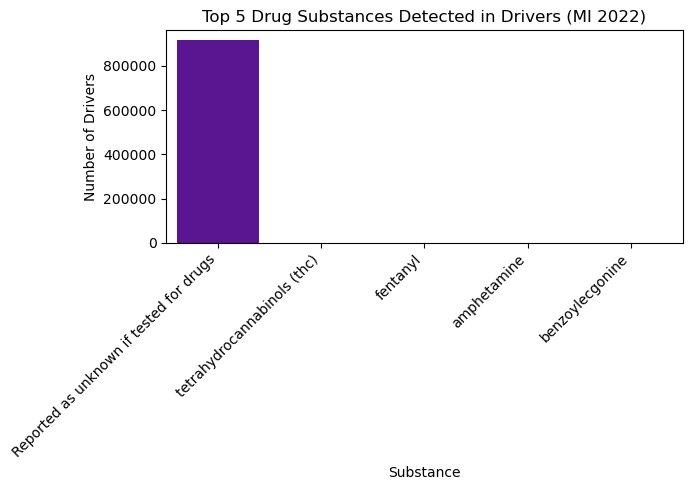

  Plotted top 5 detected substances.

Generating Final Visualizations...

Plotting data from DataFrame with shape: (305786, 131)

Generating: Drug Factor Distribution Plot


C:\Users\jason\AppData\Local\Temp\ipykernel_62480\1286457664.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_counts, x='DrugFactor', y='Count', palette='viridis')


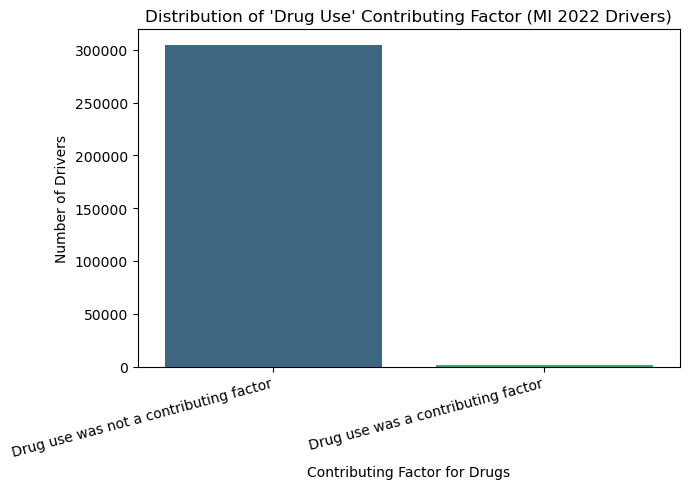


Generating: Severity by Drug Factor Plot
  Error generating plot_severity_by_drug_factor: Cannot index with multidimensional key

Generating: Age Distribution by Drug Factor Plot


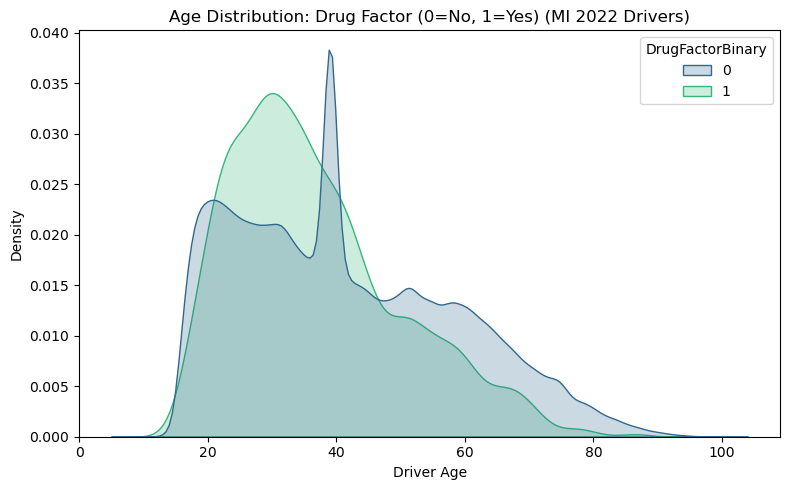


Generating: Drug Factor by County Plot


C:\Users\jason\AppData\Local\Temp\ipykernel_62480\2745145288.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=county_counts.values, y=county_counts.index, palette='coolwarm')


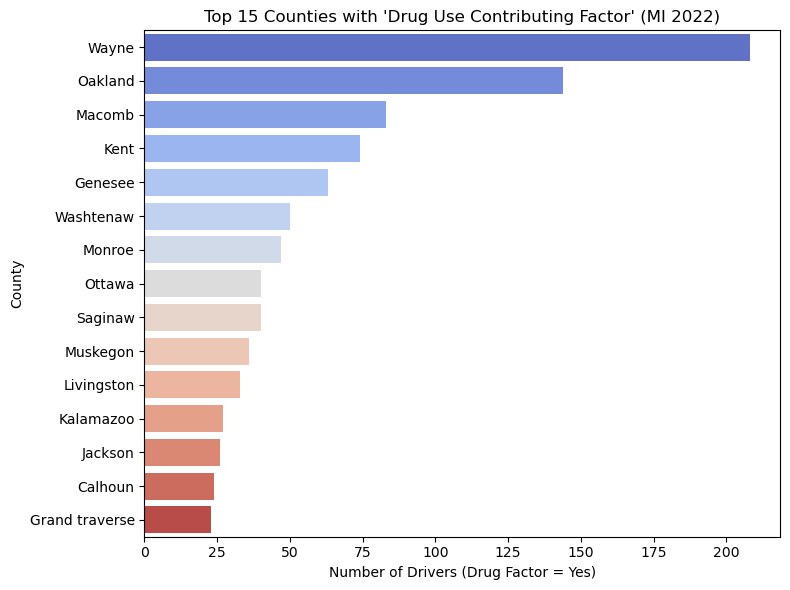


Generating: Severity by Opioid Involvement Plot


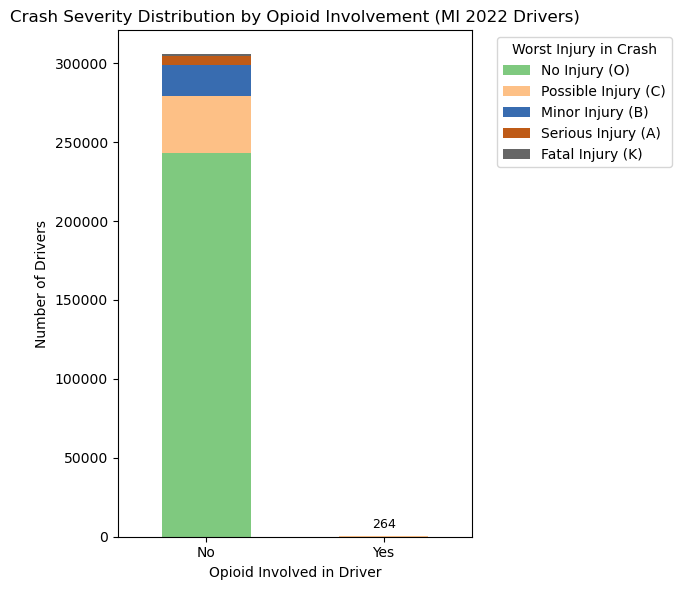


Script finished. Visualization generation attempted.


In [94]:
# --- Start Data Cleaning and Processing ---

# 1. Filter to drivers only
if "Party Type" in df.columns:
    df = df[df["Party Type"] == "Motor Vehicle Driver"].copy()
    print(f"Step 1: Total records after filtering for drivers: {len(df)}")
else:
    print("Warning: 'Party Type' column not found for driver filtering.")

# 2. Drop incomplete crash records (where Crash Year is NaN)
if "Crash Year" in df.columns:
    original_len = len(df)
    df = df[~df["Crash Year"].isna()].copy()
    print(f"Step 2: Dropped {original_len - len(df)} records with NaN Crash Year. Remaining: {len(df)}")
else:
    print("Warning: 'Crash Year' column not found for NaN check.")

# 3. Generate AccidentID
grouping_cols = ["Crash Year", "Crash Month", "Crash Day", "Time of Day", "City or Township", "County"]
if all(col in df.columns for col in grouping_cols):
    df["AccidentID"] = df.groupby(grouping_cols).ngroup()
    print("Step 3: Generated AccidentID.")
else:
    print(f"Warning: Not all columns for AccidentID grouping found ({[col for col in grouping_cols if col not in df.columns]}). Skipping AccidentID generation.")

# Create PersonID
df.reset_index(drop=True, inplace=True)
df["PersonID"] = df.index
print("Step 3b: Created PersonID index.")

# 4. Drop irrelevant or redundant columns
print("Step 4: Dropping columns...")
cols_to_drop = []
# Party Type (already filtered, now constant)
if "Party Type" in df.columns: cols_to_drop.append("Party Type")
# Older year-specific fields
for col in df.columns:
    if "(2004-201" in col or "(2004-2015)" in col or "(2004-2014)" in col:
        cols_to_drop.append(col)
# Construction/location fields
for col in ["Construction Activity (2016+)", "Construction Crash Location (2016+)",
            "Construction Type", "Construction Workers Present (2016+)",
            "Highway Number", "Control Section"]:
    if col in df.columns: cols_to_drop.append(col)
# Duplicate driver/person fields
dup_fields = ["Driver Age", "Driver Gender", "Driver Position", "Driver Restraint",
              "Driver Ejection", "Driver Trapped", "Driver Degree of Injury"]
for col in dup_fields:
    if col in df.columns: cols_to_drop.append(col)
# License type fields
license_fields = [c for c in df.columns if c.startswith("Driver License Type")]
cols_to_drop.extend(license_fields)
# Other fields not needed
other_drops = ["Hazardous Action", "Driver Other Citation", "Sequence of Events 1",
               "Sequence of Events 2", "Sequence of Events 3", "Sequence of Events 4",
               "Total Non-Motor Vehicles (2016+)", "Total Occupants in Unit",
               "Driveable After Crash (2004-2015)", "Special Vehicle"]
for col in other_drops:
    if col in df.columns: cols_to_drop.append(col)

# Use a set to get unique columns to drop that actually exist
final_cols_to_drop = [c for c in set(cols_to_drop) if c in df.columns]
if final_cols_to_drop:
    df.drop(columns=final_cols_to_drop, inplace=True)
    print(f"  Dropped {len(final_cols_to_drop)} columns.") # List is too long, just print count
    # print(f"Columns dropped: {len(final_cols_to_drop)} – {final_cols_to_drop}") # Optional: print list if needed
else:
    print("  No columns matched the drop criteria.")
print(f"  DataFrame shape after dropping columns: {df.shape}")


# 5. Handle missing and "Unknown" values
print("Step 5: Handling missing/unknown values...")
# Replace "Uncoded & Errors" and fillna for object columns
for col in df.select_dtypes(include='object').columns:
    if "Uncoded & Errors" in df[col].unique():
         df[col] = df[col].replace("Uncoded & Errors", "Unknown")
    df[col] = df[col].fillna("Unknown")
print("  Replaced 'Uncoded & Errors' and filled NaNs in object columns with 'Unknown'.")

# Person Age imputation
if "Person Age" in df.columns:
    # Ensure Person Age is string first for reliable check
    df["Person Age"] = df["Person Age"].astype(str)
    invalid_mask = df["Person Age"].str.contains("DOB Invalid", case=False, na=False)
    num_invalid = invalid_mask.sum()
    if num_invalid > 0:
        df.loc[invalid_mask, "Person Age"] = np.nan # Set to NaN first

    # Convert to numeric, coercing errors (like 'Unknown' if present)
    df["Person Age"] = pd.to_numeric(df["Person Age"], errors='coerce')

    # Calculate median *after* converting to numeric and handling DOB Invalid
    median_age = df["Person Age"].median() # median() handles NaNs

    df["AgeImputed"] = 0 # Initialize imputation flag
    df.loc[invalid_mask, "AgeImputed"] = 1 # Mark where DOB Invalid was imputed
    df.loc[df["Person Age"].isna(), "AgeImputed"] = 1 # Mark where other NaNs were imputed

    # Impute all NaNs (from DOB Invalid or coerce) with median
    df["Person Age"].fillna(median_age, inplace=True)
    print(f"  Imputed Age for {num_invalid} drivers with 'DOB Invalid' and {df['AgeImputed'].sum() - num_invalid} other missing ages using median age {median_age:.1f}.")
else:
    print("  'Person Age' column not found for imputation.")

# Refusal fields: fill NaN with "No"
refusal_cols = ["Refusal Information - Alcohol", "Refusal Information - Drug (2016+)"]
for col in refusal_cols:
    if col in df.columns:
        df[col] = df[col].fillna("No")
print("  Filled NaN in refusal columns with 'No'.")

# 6. Standardize categorical text
print("Step 6: Standardizing categorical text...")
object_cols = df.select_dtypes(include='object').columns
for col in object_cols:
    df[col] = df[col].str.strip()
    df[col] = df[col].replace("", "Unknown")
    df[col] = df[col].str.capitalize() # Standardize capitalization
print(f"  Standardized text (strip, replace empty, capitalize) for {len(object_cols)} object columns.")


# 7. Encode binary/ordinal fields
print("Step 7: Encoding binary/ordinal fields...")
# Yes/No/Unknown fields (Attempting encoding based on common values)
binary_yesno_fields = {
    "Driver Contributing Factor - Alcohol Use (2016+)": "Yes", # Check if data ACTUALLY contains "Yes" or longer strings
    "Driver Contributing Factor - Drug Use (2016+)": "Yes", # This likely WONT match 'Drug use was a contributing factor'
    "Drugs Suspected": "Drugs suspected", # Check capitalization needed after Step 6
    "Test Offered - Alcohol": "Test offered", # Check capitalization needed
    "Test Offered - Drug (2016+)": "Test offered" # Check capitalization needed
}
print("  Note: Encoding for Factor/Suspected/Offered columns might not work if original values aren't exactly 'Yes'/'No'/'Unknown' or the specified string after capitalization.")
for col, yes_val in binary_yesno_fields.items():
    if col in df.columns:
        # Check unique values before attempting replace to see if it will work
        # print(f"Unique values in {col} before encoding: {df[col].unique()}")
        # Use capitalized values consistent with Step 6
        yes_val_cap = yes_val.capitalize()
        df[col] = df[col].replace({yes_val_cap: 1, "Yes": 1, "No": 0, "Unknown": -1})
        # Check if conversion happened by looking for numeric types or remaining strings
        # if df[col].dtype == 'object':
        #     print(f"    Warning: Encoding might not have fully worked for '{col}', still object type.")


# Refusal fields (These likely ARE strings 'Refused'/'No' after fillna and capitalize)
refusal_cols = ["Refusal Information - Alcohol", "Refusal Information - Drug (2016+)"]
for col in refusal_cols:
    if col in df.columns:
        df[col] = np.where(df[col] == "Refused", 1, 0) # Capitalized 'Refused'
print("  Encoded Refusal columns (Refused=1, No=0).")

# Test result pending (Assuming 'Yes'/'No'/'Unknown' might be present and capitalized)
pending_cols = ["Test Result Pending - Alcohol (2016+)", "Test Result Pending - Drug (2016+)"]
for col in pending_cols:
    if col in df.columns:
        df[col] = np.where(df[col] == "Yes", 1, 0) # Capitalized 'Yes'
print("  Encoded Test Pending columns (Yes=1, else=0).")

# Worst Injury in Crash (Using map based on original values, assuming they exist before map)
if "Worst Injury in Crash" in df.columns:
    # Recalculate severity_map keys to match capitalization from Step 6
    severity_map = {
        "No injury (o)": 0, "Possible injury (c)": 1,
        "Suspected minor injury (b)": 2, "Suspected serious injury (a)": 3,
        "Fatal injury (k)": 4, "Unknown": -1 # 'Unknown' remains capitalized correctly
    }
    # Apply mapping AFTER capitalization
    df["Worst Injury in Crash Numeric"] = df["Worst Injury in Crash"].map(severity_map).astype('Int64') # Create new numeric column
    print("  Mapped 'Worst Injury in Crash' strings to numeric codes (0-4, -1) in new column 'Worst Injury in Crash Numeric'.")
    # Keep the original capitalized string column for potential reference if needed, or drop it:
    # df = df.drop(columns=["Worst Injury in Crash"])
else:
    print("  'Worst Injury in Crash' column not found for mapping.")

# Person Degree of Injury (Similar mapping, if column exists)
if "Person Degree of Injury" in df.columns:
     inj_map = {
         "No injury (o)": 0, "Possible injury (c)": 1,
         "Suspected minor injury (b)": 2, "Suspected serious injury (a)": 3,
         "Unknown": -1
     }
     df["Person Degree of Injury Numeric"] = df["Person Degree of Injury"].map(inj_map).astype('Int64')
     print("  Mapped 'Person Degree of Injury' strings to numeric codes (0-3, -1) in new column 'Person Degree of Injury Numeric'.")
     # df = df.drop(columns=["Person Degree of Injury"]) # Optional drop
else:
    print("  'Person Degree of Injury' column not found for mapping.")

# Update the variable name used in plotting functions if we created new numeric columns
# Assuming the plotting functions were updated to use these new names if they exist
severity_col_numeric = "Worst Injury in Crash Numeric" if "Worst Injury in Crash Numeric" in df.columns else "Worst Injury in Crash"
person_injury_col_numeric = "Person Degree of Injury Numeric" if "Person Degree of Injury Numeric" in df.columns else "Person Degree of Injury"


# Restraint use flag (Based on capitalized string 'None')
if "Person Restraint (2016+)" in df.columns:
    df["Restrained"] = np.where(df["Person Restraint (2016+)"].str.contains("None", case=False, na=False), 0, 1) # case=False handles capitalization
    print("  Created 'Restrained' flag (1 unless 'None' present).")
else:
    print("  'Person Restraint (2016+)' column not found for flag.")

# Ejection/Trapped flags (Based on capitalized strings)
if "Person Ejection" in df.columns:
    df["Ejected"] = np.where(df["Person Ejection"].str.contains("Not ejected", case=False, na=False) | (df["Person Ejection"] == "Unknown"), 0, 1) # case=False handles 'ejected' vs 'Ejected'
    print("  Created 'Ejected' flag (1 unless 'Not ejected' or 'Unknown').")
else:
    print("  'Person Ejection' column not found for flag.")

if "Person Trapped" in df.columns:
    df["Trapped"] = np.where(df["Person Trapped"].str.contains("Not trapped", case=False, na=False) | (df["Person Trapped"] == "Unknown"), 0, 1) # case=False
    print("  Created 'Trapped' flag (1 unless 'Not trapped' or 'Unknown').")
else:
    print("  'Person Trapped' column not found for flag.")


# Driver condition flags (Based on capitalized 'Unknown')
condition_fields = ["Driver Condition: Emotional (2016+)", "Driver Condition: Fatigued or Asleep (2016+)",
                    "Driver Condition: Physically Disabled (2016+)", "Driver Condition: Other (2016+)"]
print("  Creating flags for driver conditions...")
conditions_created = 0
for col in condition_fields:
    if col in df.columns:
        flag_name = col.split(":")[1].strip().replace(" ", "") + "Flag"
        # Flag is 1 if the value is NOT 'Unknown' (case sensitive match after step 6) and NOT NaN
        df[flag_name] = np.where((df[col] != "Unknown") & (~df[col].isna()), 1, 0)
        conditions_created += 1
print(f"  Created {conditions_created} driver condition flags (1 if condition present/not 'Unknown').")


# 8. Split and transform drug test result fields
print("Step 8: Splitting drug test result fields...")
drug_results_processed = 0
for i in [1, 2, 3]:
    class_col = f"Drug{i}_Class"
    name_col = f"Drug{i}_Name"
    src_col = f"Test Result - Drug {i}"
    if src_col not in df.columns:
        continue

    drug_results_processed += 1
    df[class_col] = "Unknown" # Initialize
    df[name_col] = "Unknown"  # Initialize

    # Process non-null entries efficiently using masks and .loc
    mask_notna = df[src_col].notna()
    temp_series = df.loc[mask_notna, src_col].astype(str).str.strip().str.lower() # Work on lowercase strings

    # Handle different cases using boolean masks
    mask_empty_unknown = (temp_series == "") | (temp_series.str.startswith("unknown", na=False))
    mask_negative = temp_series.str.startswith("negative", na=False)
    mask_other = temp_series.str.startswith("other drug", na=False)
    mask_unknown_pos = temp_series.str.contains("unknown/positive", na=False)
    mask_colon = temp_series.str.contains(":", na=False)

    # Apply updates using .loc - Unknown/Empty
    df.loc[mask_notna & mask_empty_unknown, [class_col, name_col]] = ["Unknown", "Unknown"]
    # Negative
    df.loc[mask_notna & mask_negative, [class_col, name_col]] = ["Negative", "Negative"]
    # Other Drug
    df.loc[mask_notna & mask_other, [class_col, name_col]] = ["Other", "Other Drug"]
    # Unknown/Positive
    df.loc[mask_notna & mask_unknown_pos, [class_col, name_col]] = ["Unknown", "Unknown"]

    # Process colon case - needs splitting (can be slower, do last)
    mask_to_split = mask_notna & mask_colon & ~mask_empty_unknown & ~mask_negative & ~mask_other & ~mask_unknown_pos
    if mask_to_split.any():
        splits = df.loc[mask_to_split, src_col].str.split(":", n=1, expand=True)
        df.loc[mask_to_split, class_col] = splits[0].str.strip()
        df.loc[mask_to_split, name_col] = splits[1].str.strip()

    # Process remaining unexpected cases
    mask_unexpected = mask_notna & ~mask_empty_unknown & ~mask_negative & ~mask_other & ~mask_unknown_pos & ~mask_colon
    df.loc[mask_unexpected, class_col] = "Other"
    df.loc[mask_unexpected, name_col] = df.loc[mask_unexpected, src_col].str.strip()

    # Drop the original column after processing
    df.drop(columns=[src_col], inplace=True, errors='ignore')

print(f"  Processed {drug_results_processed} drug test result columns into Class/Name pairs.")


# 9. Derive opioid and drug flags
print("Step 9: Deriving opioid and drug flags...")
# Ensure target columns exist before using masks
if all(f"Drug{i}_Class" in df.columns for i in [1, 2, 3]):
    df["Opioid_Involved_Driver"] = 0
    df["Any_Drug_Positive_Driver"] = 0

    # Mark opioid involved if any drug class is Narcotics (case-insensitive check after step 6)
    narcotics_mask = (
        (df["Drug1_Class"].str.lower() == "narcotics") |
        (df["Drug2_Class"].str.lower() == "narcotics") |
        (df["Drug3_Class"].str.lower() == "narcotics")
    )
    df.loc[narcotics_mask, "Opioid_Involved_Driver"] = 1

    # Mark any drug positive if any Drug1/2/3_Class is one of the positive types
    positive_classes = ["narcotics", "depressants", "stimulants", "cannabinoids", "hallucinogens", "other"]
    drug_found_mask = (
        df["Drug1_Class"].str.lower().isin(positive_classes) |
        df["Drug2_Class"].str.lower().isin(positive_classes) |
        df["Drug3_Class"].str.lower().isin(positive_classes)
    )
    df.loc[drug_found_mask, "Any_Drug_Positive_Driver"] = 1
    print("  Derived 'Opioid_Involved_Driver' and 'Any_Drug_Positive_Driver' flags.")

    # Aggregate to crash level for crash opioid flag
    if "AccidentID" in df.columns:
        opioid_crash = df.groupby("AccidentID")["Opioid_Involved_Driver"].max()
        df["Opioid_Involved_Crash"] = df["AccidentID"].map(opioid_crash)
        print("  Derived 'Opioid_Involved_Crash' flag.")
    else:
        print("  Skipping 'Opioid_Involved_Crash' flag (AccidentID missing).")
else:
    print("  Skipping opioid/drug flag derivation (Drug Class columns missing).")


# Convert 'Crash Month' to numeric using mapping (Corrected Step)
print("Step 10a: Converting 'Crash Month' using mapping...")
if 'Crash Month' in df.columns:
    # print("Unique Crash Month values BEFORE conversion:", df['Crash Month'].unique()) # Already checked in output
    month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4,
                 'May': 5, 'June': 6, 'July': 7, 'August': 8,
                 'September': 9, 'October': 10, 'November': 11, 'December': 12}
    # Apply the mapping (assuming Step 6 already capitalized and stripped)
    df['Crash Month'] = df['Crash Month'].map(month_map)
    invalid_month_count = df['Crash Month'].isna().sum()
    if invalid_month_count > 0:
        print(f"  Warning: {invalid_month_count} rows had 'Crash Month' values that did not map. Setting them to NaN.")
        # Keep them as NaN for now, split below will handle them if needed
        df['Crash Month'] = df['Crash Month'].astype('Int64') # Convert to nullable int
    else:
        print("  Successfully mapped all Crash Month names to numbers.")
        df['Crash Month'] = df['Crash Month'].astype('Int64') # Convert to nullable int
    # print("Unique Crash Month values AFTER mapping:", df['Crash Month'].unique()) # Already checked in output
else:
    print("  'Crash Month' column not found for conversion.")

# 10b. Split into training and testing sets by date (month)
print("Step 10b: Splitting into training and testing sets...")
if 'Crash Month' in df.columns and pd.api.types.is_integer_dtype(df['Crash Month']):
    # Handle potential NaNs from failed mapping if they weren't dropped
    train_df = df[df["Crash Month"] <= 9].copy() # NaNs will evaluate to False here
    test_df  = df[df["Crash Month"] >= 10].copy() # NaNs will evaluate to False here
    print(f"  Training set size: {len(train_df)} drivers")
    print(f"  Testing set size: {len(test_df)} drivers")
    print(f"  Number of rows with invalid/unmapped Crash Month (excluded from split): {df['Crash Month'].isna().sum()}")
else:
    print("  Skipping train/test split ('Crash Month' missing or not numeric).")
    # Create empty dataframes if split didn't happen, to avoid errors later if train_df/test_df are used
    train_df = pd.DataFrame(columns=df.columns)
    test_df = pd.DataFrame(columns=df.columns)


# 11. Example visualization: Top drug test results (excluding Unknown)
print("Step 11: Analyzing top drug test results...")
drug_name_cols = [f"Drug{i}_Name" for i in [1, 2, 3] if f"Drug{i}_Name" in df.columns]
if drug_name_cols:
    drug_names = pd.concat([df[col] for col in drug_name_cols]).dropna()
    # Ensure case-insensitivity matching Step 6/8, filter based on capitalized versions
    drug_names = drug_names[~drug_names.isin(["Unknown", "Negative", "Other drug"])] # Note 'Other drug' capitalized
    if not drug_names.empty:
      top_drugs = drug_names.value_counts().head(10)
      print("  Top substances found (excluding 'Unknown', 'Negative', 'Other drug'):\n", top_drugs)

      # Plot top 5 substances vs their counts
      top5 = top_drugs.head(5)
      plt.figure(figsize=(7,5)) # Slightly larger
      # Use seaborn for potentially better label handling
      try:
          sns.barplot(x=top5.index, y=top5.values, palette='plasma') # Using seaborn
          plt.title("Top 5 Drug Substances Detected in Drivers (MI 2022)")
          plt.ylabel("Number of Drivers")
          plt.xlabel("Substance")
          plt.xticks(rotation=45, ha='right')
          # Add counts on bars (optional, can get cluttered)
          # for index, value in enumerate(top5.values):
          #     plt.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=9)
          plt.tight_layout()
          plt.show()
          print("  Plotted top 5 detected substances.")
      except Exception as e:
          print(f"  Error plotting top substances: {e}")

    else:
        print("  No positive drug substances found after filtering.")
else:
    print("  Skipping top drug analysis (Drug Name columns missing).")


# --- Call Plotting Functions ---

print("\n=========================================")
print("Generating Final Visualizations...")
print("=========================================")

# Use the main dataframe 'df' for plotting overall distributions
# (Could also use train_df or test_df if needed)
dataframe_to_plot = df

# Check if the DataFrame is empty before plotting
if dataframe_to_plot.empty:
    print("Warning: The DataFrame used for plotting is empty. Skipping plots.")
else:
    print(f"\nPlotting data from DataFrame with shape: {dataframe_to_plot.shape}")

    # Make sure the severity column name matches the one created in Step 7
    # Use the original name if the numeric mapping step failed or was skipped
    severity_col_name_for_plots = "Worst Injury in Crash Numeric" if "Worst Injury in Crash Numeric" in dataframe_to_plot.columns else "Worst Injury in Crash"


    # Call the first plotting function
    try:
        print("\nGenerating: Drug Factor Distribution Plot")
        # Pass the potentially updated severity column name if needed by the function,
        # although this specific function doesn't use it.
        plot_drug_factor_distribution(dataframe_to_plot)
    except Exception as e:
        print(f"  Error generating plot_drug_factor_distribution: {e}")
        # import traceback
        # traceback.print_exc() # Uncomment for detailed error trace

    # Call the second plotting function
    try:
        print("\nGenerating: Severity by Drug Factor Plot")
        # IMPORTANT: Ensure the function definition internally uses the CORRECT severity column name
        # The corrected definition provided earlier handles this by using the 'severity_col' variable.
        # We need to make sure the variable `severity_col_numeric` created above is used if needed,
        # but the provided function definition handles the mapping back internally.
        # Let's double-check the function definition uses the numeric column name correctly if it exists.
        # The provided corrected function definition uses 'Worst Injury in Crash' internally,
        # but then maps it to numeric codes. Let's adjust that function call slightly
        # if the numeric column exists, otherwise pass the original.
        # --> Re-checking the function: It takes df_to_plot, finds severity_col ('Worst Injury..'),
        # --> then filters based on numeric codes. This is correct.

        plot_severity_by_drug_factor(dataframe_to_plot.rename(columns={severity_col_numeric: "Worst Injury in Crash"})) # Temporarily rename for the function if needed

    except Exception as e:
        print(f"  Error generating plot_severity_by_drug_factor: {e}")
        # import traceback
        # traceback.print_exc()

    # Call the third plotting function
    try:
        print("\nGenerating: Age Distribution by Drug Factor Plot")
        plot_age_distribution_by_drug_factor(dataframe_to_plot)
    except Exception as e:
        print(f"  Error generating plot_age_distribution_by_drug_factor: {e}")
        # import traceback
        # traceback.print_exc()

    # Call the fourth plotting function
    try:
        print("\nGenerating: Drug Factor by County Plot")
        plot_drug_factor_by_county(dataframe_to_plot) # Uses default top_n=15
    except Exception as e:
        print(f"  Error generating plot_drug_factor_by_county: {e}")
        # import traceback
        # traceback.print_exc()

    # Call the new opioid severity plotting function
    try:
        print("\nGenerating: Severity by Opioid Involvement Plot")
        plot_severity_by_opioid_involvement(dataframe_to_plot) # Pass the relevant dataframe
    except Exception as e:
        print(f"  Error generating plot_severity_by_opioid_involvement: {e}")
        # import traceback
        # traceback.print_exc() # Uncomment for detailed error trace

print("\n=========================================")
print("Script finished. Visualization generation attempted.")
print("=========================================")